In [37]:
%load_ext autoreload
%autoreload 2
import jax, optax
from jax import numpy as jnp
from flax import nnx
from models import LeNet, teleport_lenet
from data import get_gaze
from fedflax import train
from functools import reduce
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
n_clients = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## One-shot training

In [2]:
# Optimizer
opt_create = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# Loss includes softmax layer
def ell(model, _, x_batch, z_batch, y_batch, train):
    ce = optax.softmax_cross_entropy(model(x_batch, z_batch, train=train), y_batch).mean()
    return ce, (0., 0.)

# Train
ds_train = get_gaze(beta=.5, n_clients=n_clients)
ds_val = get_gaze(beta=.5, partition="val", n_clients=n_clients, batch_size=16)
_, models = train(LeNet(nnx.Rngs(0)), opt_create, ds_train, ds_val, ell, local_epochs=50, rounds=1, n=n_clients)

Round 0 Epoch 19/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 20/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 21/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 22/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 23/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 24/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 25/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 26/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 27/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 28/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 29/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 30/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 31/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 32/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 33/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 34/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 35/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 36/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 37/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 38/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 39/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 40/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 41/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 42/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 43/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 44/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 45/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 46/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 47/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 48/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 49/50:   0%|          | 0/19 [00:00<?, ?it/s]

Round 0 Epoch 50/50:   0%|          | 0/19 [00:00<?, ?it/s]

round 0 validation accuracy (mean over clients): 0.485119104385376


## Sample levelset and teleport
In reality, the measurements are taken strictly at the client-side, whereas the teleportation can occur at the server.

In [ ]:
# TODO: instead of random, these should be perpendicular to gradient
perturbkey = jax.random.key(42)

# Test dataset and accuracy function
ds_test = get_gaze(beta=.5, partition="test", n_clients=n_clients, batch_size=32)
acc_fn = nnx.jit(nnx.vmap(lambda m,x,z,y: (m(x,z).argmax(-1)==y.argmax(-1)).mean()))
test_errs_orig = 1 - reduce(lambda cum, batch: cum + acc_fn(models, *batch), ds_test, 0.) / len(ds_test)

# Explore landscape by measuring accuracy of perturbed models
models_perturbs = [models]
test_errses = [test_errs_orig]
n_p = 20
for _ in range(n_p):
    # Sample models in the levelset
    def unit_random(shape): 
        global perturbkey
        _, perturbkey = jax.random.split(perturbkey)
        v = jax.random.normal(perturbkey, shape)
        return v / jnp.linalg.norm(v)
    models_perturb = nnx.from_tree(jax.tree.map(
        lambda p: p + unit_random(p.shape),
        nnx.to_tree(models)
    ))
    models_perturbs.append(models_perturb)
    # Measure their accuracy
    test_errs_perturb = 1 - reduce(lambda cum, batch: cum + acc_fn(models_perturb, *batch), ds_test, 0.) / len(ds_test)
    test_errses.append(test_errs_perturb)
test_errses = jnp.stack(test_errses, axis=1)

# Teleport original models (all perturbed models get the same random teleportation)
telekey = jax.random.key(24)
models_perturbs_teles = []
n_t = 3
for _ in range(n_t):
    # Loop over perturbations
    models_perturbs_tele = []
    for models_perturb in models_perturbs:
        # Teleport to a different region in parameter space while retaining network function
        models_perturb_tele = nnx.vmap(teleport_lenet, in_axes=(0, None, None))(models_perturb, telekey)
        models_perturbs_tele.append(models_perturb_tele)
    # Collect teleportations of all perturbations of all clients
    models_perturbs_teles.append(models_perturbs_tele)
    _, telekey = jax.random.split(telekey)

## Display in 2D subspace

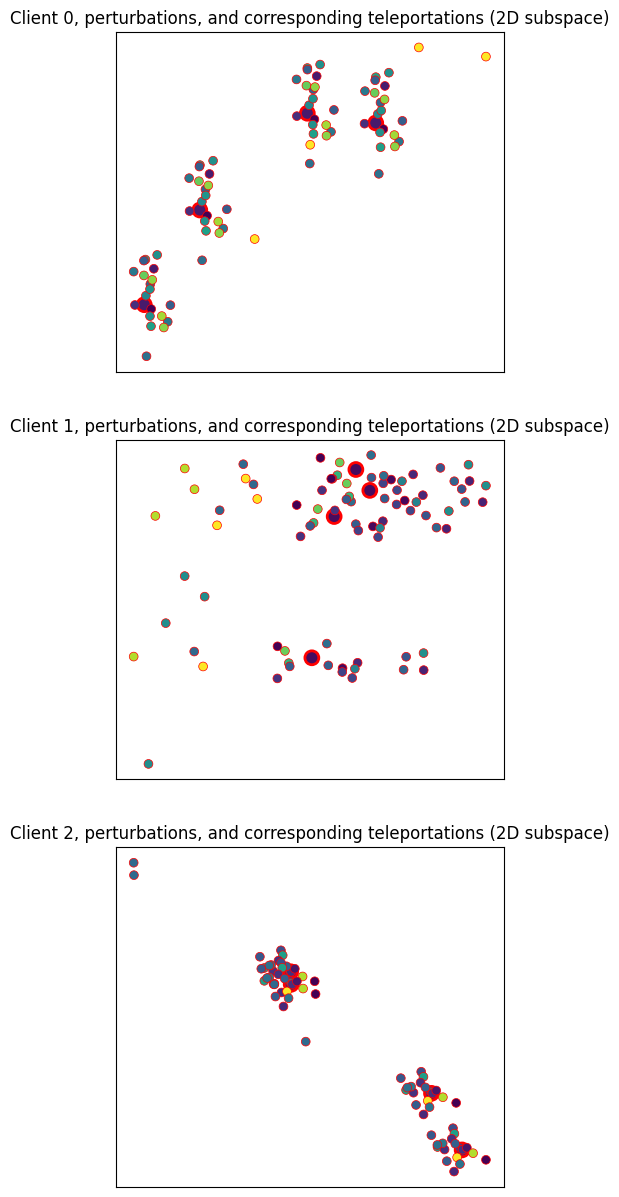

In [ ]:
# Reduce high-dimensional params to 2D for visualization
pca = PCA(n_components=2)
params_flat = jnp.stack([ # shape: ((n_t+1)*(n_p+1), n_clients, n_params)
    jnp.concat([p.reshape(n_clients,-1) for p in jax.tree.leaves(nnx.to_tree(models_perturb_tele))], axis=1) # flatten params of each client
    for models_perturbs_tele in models_perturbs_teles+[models_perturbs] for models_perturb_tele in models_perturbs_tele
])
params_2d = pca.fit_transform(params_flat.reshape(((n_t+1)*(n_p+1))*n_clients, -1)).reshape((n_t+1)*(n_p+1), n_clients, 2).swapaxes(0,1)

fig, axs  = plt.subplots(n_clients, dpi=100, figsize=(5,n_clients*5));
for client, ax in enumerate(axs):
    # Manually map error to colors
    cmap = jnp.array(plt.get_cmap("viridis").colors)
    c_idx = len(cmap) * (test_errses[client]-test_errses[client].min()) // (test_errses[client].max() - test_errses[client].min())
    c_idx = jnp.tile(c_idx.astype(int), n_t+1)
    # Display points on plot
    ax.scatter(
        params_2d[client, :, 0], params_2d[client, :, 1], 
        c=cmap[c_idx], 
        linewidths=jnp.array([.5]*(n_t+1)*(n_p+1)).at[::n_p+1].set(2),
        edgecolors="red", 
        s=jnp.array([40]*(n_t+1)*(n_p+1)).at[::n_p+1].set(100));
    # Axes are meaningless
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.set_title(f"Client {client}, perturbations, and corresponding teleportations (2D subspace)");